In [1]:
#importing libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,RocCurveDisplay
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering
from fcmeans import FCM
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data=pd.read_csv("players_21.csv")
df=data.copy()
#إزالة بعض الأعمدة غير الضرورية:
df.drop(["ls","st","rb","rcb","cb","lcb","lb","rwb","rdm","cdm","ldm","lwb","rm","rcm","cm","rs","lcm","lm","ram","cam","lam","rw","rf","cf","lf","lw"],axis=1,inplace=True)

In [3]:
print('Shape of the data:',df.shape)
print("-------------------------------")
df.head()

Shape of the data: (18944, 80)
-------------------------------


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Injury Prone, Flair, Speed Dribbler (AI), Outs...",85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11


# FEATURE ENGINEERING

In [4]:
# convert object features to datetime
from datetime import datetime as dt
df["dob"]=pd.to_datetime(df["dob"])
df["joined"]=pd.to_datetime(df["joined"])
df["born_year"]=df["dob"].dt.year

# تحويل القيم المالية من اليورو إلى الملايين،سعر اللاعب-راتب-شرط جزائي.
df["value_eur"]=df["value_eur"]/1000000
df["wage_eur"]=(df["wage_eur"]*48)/1000000
df["release_clause_eur"]=df["release_clause_eur"]/1000000

#إعادة تسمية
df.rename(columns={"value_eur":"value_eur_m","wage_eur":"wage_eur_m","release_clause_eur":"release_clause_eur_m"},inplace=True)

# CREATE NEW FEATURES:
# league value:
#The total value of players is calculated for each league and divided by 1000
df["league_value_2"]=df.groupby("league_name")["value_eur_m"].transform("sum")/1000

# position_area(attack,defense,midfield,goalkeeper):
df["team_position"]=df["team_position"].apply(lambda x: 0 if x in ["LS","ST","RS","LW","LF","CF","RF","RW"] 
                                              else (1 if x in ["LWB","LB","LCB","CB","RCB","RB"] else 
                                                    (3 if x in ["LDM","CDM","RDM","LM","LCM","CM","RCM","RM","LAM","CAM","RAM"] 
                                                     else(4 if x in ["GK"] else 5))))

# the values that starts by "PLAYER_BODY_TYPE_" then number للاعبين غير المشهورين so make it "not famous" else make it "famous"
df["body_type"]=df["body_type"].apply(lambda x: "not famous" if x.startswith("PLAYER_BODY_TYPE_") else "famous")
                                                                                
# حساب عدد الصفات لكل لاعب
#If the value of the column 'player_traits' is of type str (string), the text is split into parts using the comma (,).
#Then, the number of resulting parts is calculated using len(). If the value is not of type str, the value is assigned as 0 (indicating that the player has no traits).
df["player_traits"]=df["player_traits"].apply(lambda x: len(x.split(",")) if type(x)==str else 0)

# يتم تصنيف الفرق إلى فرق ذات جودة عالية وفرق ذات جودة منخفضة بناءً على إجمالي قيمة اللاعبين في كل فريق
vf=df.groupby("club_name")[["value_eur_m"]].sum().sort_values(by="value_eur_m",ascending=False).head(100)
df["team_quality"]=df["club_name"].apply(lambda x: "hight_quality" if x in vf.index else "low_quality")

# card type (gold,silver,bronze):
df["card_type"]=df["overall"].apply(lambda x: 0 if x > 74 
                                              else (1 if (x > 64 and x < 75) 
                                                else (2 if x < 65 else 3 )))

print('Shape of the data:',df.shape)
print("-------------------------------")
df.head()


Shape of the data: (18944, 84)
-------------------------------


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur_m,wage_eur_m,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur_m,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,born_year,league_value_2,team_quality,card_type
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67.5,26.88,"RW, ST, CF",Left,5,4,4,Medium/Low,famous,Yes,138.4,"#Dribbler, #Distance Shooter, #FK Specialist, ...",3,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,8,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,1987,5.266865,hight_quality,0
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46.0,10.56,"ST, LW",Right,5,4,5,High/Low,famous,Yes,75.9,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",0,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,5,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,1985,3.984970,hight_quality,0
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75.0,6.00,GK,Right,3,3,1,Medium/Medium,not famous,Yes,159.4,NaN,4,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,2,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,1993,5.266865,hight_quality,0
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80.0,11.52,ST,Right,4,4,4,High/Medium,not famous,Yes,132.0,"#Distance Shooter, #Clinical Finisher",0,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,4,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,1988,3.858735,hight_quality,0
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90.0,12.96,"LW, CAM",Right,5,5,5,High/Medium,famous,Yes,166.5,"#Speedster, #Dribbler, #Playmaker, #FK Special...",0,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,5,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11,1992,2.948835,hight_quality,0


# MISSING VALUES

In [5]:
# check the missing values

# df.isnull().sum()

In [6]:
#اختيار الأعمدة التي تحتوي على قيم عددية فقط
num=df.select_dtypes(include=['float64','int64'])
#إذا كان عدد القيم المفقودة في أي عمود أكبر من 90% then delete the column
for i in df.columns:
    if df[i].isnull().sum()>len(df)*0.90:
        df.drop(i,axis=1,inplace=True)     
# df.isnull().sum()

In [7]:
# handling the missing values by using KNN imputer
#KNNImputer is a class used for imputing missing values using the k-Nearest Neighbors approach.
from sklearn.impute import KNNImputer
knn=KNNImputer(n_neighbors=15)
num=df.select_dtypes(include=['float64','int64'])    
for i in num.columns:
   df[i]=knn.fit_transform(df[[i]])
      
# df.isnull().sum()

In [8]:
df.to_csv('fifa21_without_missing.csv', index=False)

In [9]:
df.head(8)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur_m,wage_eur_m,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur_m,team_position,team_jersey_number,joined,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,born_year,league_value_2,team_quality,card_type
0,158023.0,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33.0,1987-06-24,170.0,72.0,Argentina,FC Barcelona,Spain Primera Division,1.0,93.0,93.0,67.5,26.88,"RW, ST, CF",Left,5.0,4.0,4.0,Medium/Low,famous,Yes,138.4,3.0,10.0,2004-07-01,2021.0,85.00000,92.000000,91.000000,95.00000,38.000000,65.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,8.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1987,5.266865,hight_quality,0.0
1,20801.0,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35.0,1985-02-05,187.0,83.0,Portugal,Juventus,Italian Serie A,1.0,92.0,92.0,46.0,10.56,"ST, LW",Right,5.0,4.0,5.0,High/Low,famous,Yes,75.9,0.0,7.0,2018-07-10,2022.0,89.00000,93.000000,81.000000,89.00000,35.000000,77.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,5.0,84.0,95.0,90.0,82.0,86.0,88.0,81.0,76.0,77.0,92.0,87.0,91.0,87.0,95.0,71.0,94.0,95.0,84.0,78.0,93.0,63.0,29.0,95.0,82.0,84.0,95.0,32.0,24.0,7.0,11.0,15.0,14.0,11.0,1985,3.984970,hight_quality,0.0
2,200389.0,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27.0,1993-01-07,188.0,87.0,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91.0,93.0,75.0,6.00,GK,Right,3.0,3.0,1.0,Medium/Medium,not famous,Yes,159.4,4.0,13.0,2014-07-16,2023.0,67.66811,52.274954,57.139434,62.45543,51.316292,64.458988,87.000000,92.000000,78.000000,90.000000,52.000000,90.000000,2.0,13.0,11.0,15.0,43.0,13.0,12.0,13.0,14.0,40.0,30.0,43.0,60.0,67.0,88.0,49.0,59.0,78.0,41.0,78.0,12.0,34.0,19.0,11.0,65.0,11.0,68.0,12.0,18.0,87.0,92.0,78.0,90.0,90.0,1993,5.266865,hight_quality,0.0
3,188545.0,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31.0,1988-08-21,184.0,80.0,Poland,FC Bayern München,German 1. Bundesliga,1.0,91.0,91.0,80.0,11.52,ST,Right,4.0,4.0,4.0,High/Medium,not famous,Yes,132.0,0.0,9.0,2014-07-01,2023.0,78.00000,91.000000,78.000000,85.00000,43.000000,82.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,4.0,71.0,94.0,85.0,84.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,78.0,77.0,93.0,82.0,89.0,84.0,76.0,86.0,85.0,81.0,49.0,94.0,79.0,88.0,88.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,1988,3.858735,hight_quality,0.0
4,190871.0,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28.0,1992-02-05,175.0,68.0,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91.0,91.0,90.0,12.96,"LW, CAM",Right,5.0,5.0,5.0,High/Medium,famous,Yes,166.5,0.0,10.0,2017-08-03,2022.0,91.00000,85.000000,86.000000,94.00000,36.000000,59.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,5.0,85.0,87.0,62.0,87.0,87.0,95.0,88.0,89.0,81.0,95.0,94.0,8

# DATA PREPROCESSING

In [10]:
# label encoding:

df1=df.copy()
df1.drop(["sofifa_id","player_url","short_name","long_name","dob","joined","club_name","league_name","player_positions","nationality"],axis=1,inplace=True)

def label_encoder(df1, column_name):
    #make sure that the culumn is a Categorical Column
    if df1[column_name].dtype == 'object':
        # if catorical column has 2 unique values, then use label encoder
        if df1[column_name].nunique() <= 2:
            le = LabelEncoder()
            df1[column_name] = le.fit_transform(df1[column_name])
            return df1
        # if categorical column has more than 2 unique values and less than 10 unique values, then use one hot encoder.
        #One-Hot Encoding creates a new column for each unique value in the original column,
        #       with a value of 1 in the column representing the original value and a value of 0 in the other new columns.
        elif df1[column_name].nunique() > 2  and df1[column_name].nunique() <= 10:
            ohe = OneHotEncoder()
            ohe_df1 = pd.DataFrame(ohe.fit_transform(df1[[column_name]]).toarray())
            ohe_df1.columns = [column_name + "_" + str(i) for i in ohe_df1.columns]
            df1 = df1.join(ohe_df1)
            df1 = df1.drop(column_name, axis=1)
            return df1
        # more than 10 unique values
        else:
            return df1
    # (not a Categorical Column)   
    else:
        return df1
        
for i in df1.columns:
    df1 = label_encoder(df1, i)

In [11]:
df1.head()

,age,height_cm,weight_kg,league_rank,overall,potential,value_eur_m,wage_eur_m,preferred_foot,international_reputation,weak_foot,skill_moves,body_type,real_face,release_clause_eur_m,team_position,team_jersey_number,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,born_year,league_value_2,team_quality,card_type,work_rate_0,work_rate_1,work_rate_2,work_rate_3,work_rate_4,work_rate_5,work_rate_6,work_rate_7,work_rate_8
0,33.0,170.0,72.0,1.0,93.0,93.0,67.5,26.88,0,5.0,4.0,4.0,0,1,138.4,3.0,10.0,2021.0,85.00000,92.000000,91.000000,95.00000,38.000000,65.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,8.0,85.0,95.0,70.0,91.0,88.0,96.0,93.0,94.0,91.0,96.0,91.0,80.0,91.0,94.0,95.0,86.0,68.0,72.0,69.0,94.0,44.0,40.0,93.0,95.0,75.0,96.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0,1987,5.266865,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,35.0,187.0,83.0,1.0,92.0,92.0,46.0,10.56,1,5.0,4.0,5.0,0,1,75.9,0.0,7.0,2022.0,89.00000,93.000000,81.000000,89.00000,35.000000,77.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,5.0,84.0,95.0,90.0,82.0,86.0,88.0,81.0,76.0,77.0,92.0,87.0,91.0,87.0,95.0,71.0,94.0,95.0,84.0,78.0,93.0,63.0,29.0,95.0,82.0,84.0,95.0,32.0,24.0,7.0,11.0,15.0,14.0,11.0,1985,3.984970,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27.0,188.0,87.0,1.0,91.0,93.0,75.0,6.00,1,3.0,3.0,1.0,1,1,159.4,4.0,13.0,2023.0,67.66811,52.274954,57.139434,62.45543,51.316292,64.458988,87.000000,92.000000,78.000000,90.000000,52.000000,90.000000,2.0,13.0,11.0,15.0,43.0,13.0,12.0,13.0,14.0,40.0,30.0,43.0,60.0,67.0,88.0,49.0,59.0,78.0,41.0,78.0,12.0,34.0,19.0,11.0,65.0,11.0,68.0,12.0,18.0,87.0,92.0,78.0,90.0,90.0,1993,5.266865,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,31.0,184.0,80.0,1.0,91.0,91.0,80.0,11.52,1,4.0,4.0,4.0,1,1,132.0,0.0,9.0,2023.0,78.00000,91.000000,78.000000,85.00000,43.000000,82.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,4.0,71.0,94.0,85.0,84.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,78.0,77.0,93.0,82.0,89.0,84.0,76.0,86.0,85.0,81.0,49.0,94.0,79.0,88.0,88.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,1988,3.858735,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28.0,175.0,68.0,1.0,91.0,91.0,90.0,12.96,1,5.0,5.0,5.0,0,1,166.5,0.0,10.0,2022.0,91.00000,85.000000,86.000000,94.00000,36.000000,59.000000,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,5.0,85.0,87.0,62.0,87.0,87.0,95.0,88.0,89.0,81.0,95.0,94.0,89.0,96.0,91.0,83.0,80.0,62.0,81.0,50.0,84.0,51.0,36.0,87.0,90.0,92.0,93.0,30.0,29.0,9.0,9.0,15.0,15.0,11.0,1992,2.948835,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df1.to_csv('labeled_data_fifa21.csv', index=False)

# Linear Regression : predicting the player value by million euros

In [13]:
x=df1.drop(["value_eur_m",'born_year','height_cm','weight_kg',"preferred_foot","weak_foot","international_reputation",'team_jersey_number'],axis=1).values
y=df1["value_eur_m"].values.reshape(-1,1)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

print("X_train shape: ",x_train.shape)
print("X_test shape: ",x_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (15155, 69)
X_test shape:  (3789, 69)
y_train shape:  (15155, 1)
y_test shape:  (3789, 1)


In [14]:
LinearRegression_model=LinearRegression()
LinearRegression_model.fit(x_train,y_train)

LinearRegression()

In [15]:
accuracy=LinearRegression_model.score(x_test,y_test)
print('This model accuracy is:',accuracy)

This model accuracy is: 0.9666241241018825


# LogisticRegression : team quality

In [16]:
x=df1.drop(["team_quality","age","born_year","height_cm","weight_kg","preferred_foot","international_reputation","weak_foot","team_position","team_jersey_number","contract_valid_until"],axis=1).values
y=df1["team_quality"].values.reshape(-1,1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)
print("X_train shape: ",x_train.shape)
print("X_test shape: ",x_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (15155, 66)
X_test shape:  (3789, 66)
y_train shape:  (15155, 1)
y_test shape:  (3789, 1)


In [17]:
LogisticRegression_model=LogisticRegression()
LogisticRegression_model.fit(x_train,y_train)

LogisticRegression()

In [18]:
accuracy=LogisticRegression_model.score(x_test,y_test)
print('This model accuracy is:',int(accuracy*100),'%')

This model accuracy is: 92 %


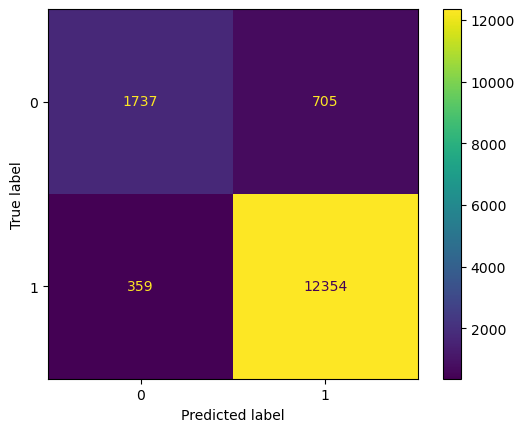

In [19]:
# Generate confusion matrix
y_pred = LogisticRegression_model.predict(x_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LogisticRegression_model.classes_)
disp.plot()
plt.show()

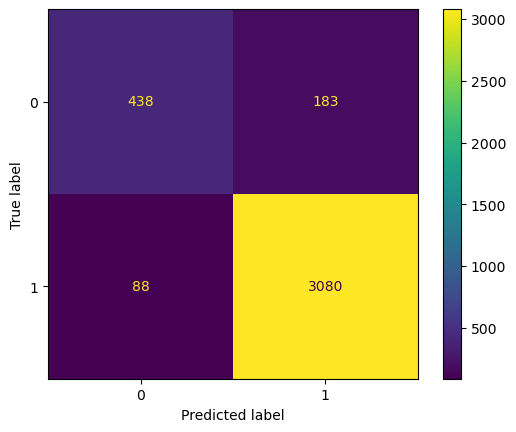

In [20]:
# Generate confusion matrix
y_pred = LogisticRegression_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

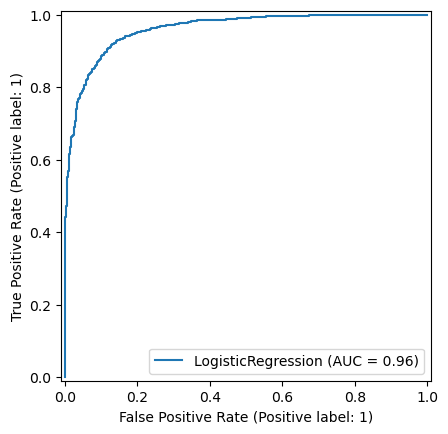

In [21]:
ROC_Curve=RocCurveDisplay.from_estimator(LogisticRegression_model,x_test,y_test)

# SVM : team quality

In [22]:
x=df1.drop(["team_quality","age","born_year","height_cm","weight_kg","preferred_foot","international_reputation","weak_foot","team_position","team_jersey_number","contract_valid_until"],axis=1).values
y=df1["team_quality"].values.reshape(-1,1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print("X_train shape: ",x_train.shape)
print("X_test shape: ",x_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (15155, 66)
X_test shape:  (3789, 66)
y_train shape:  (15155, 1)
y_test shape:  (3789, 1)


In [23]:
SVC_model=SVC(C=0.1,kernel='linear') 
SVC_model.fit(x_train, y_train)

SVC(C=0.1, kernel='linear')

In [24]:
accuracy=SVC_model.score(x_test,y_test)
print('This model accuracy is:',int(accuracy*100),'%')

This model accuracy is: 93 %


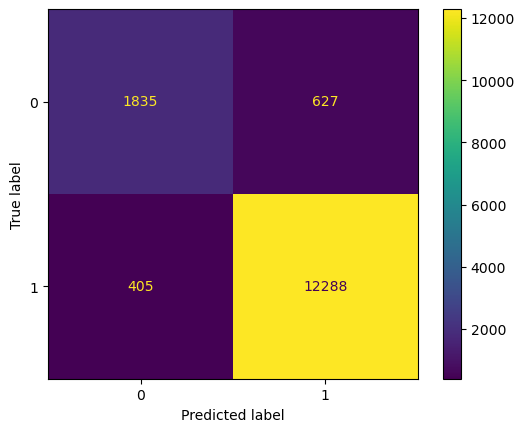

In [25]:
# Generate confusion matrix
y_pred = SVC_model.predict(x_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVC_model.classes_)
disp.plot()
plt.show()

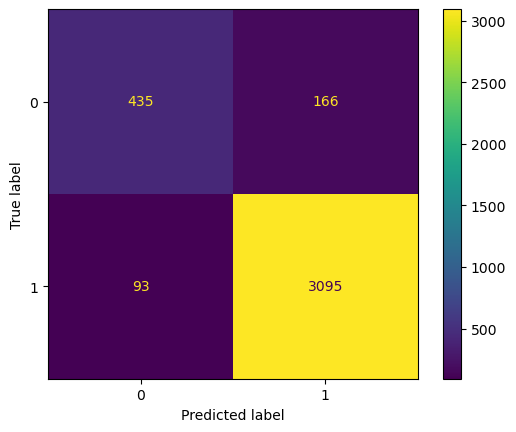

In [26]:
# Generate confusion matrix
y_pred = SVC_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

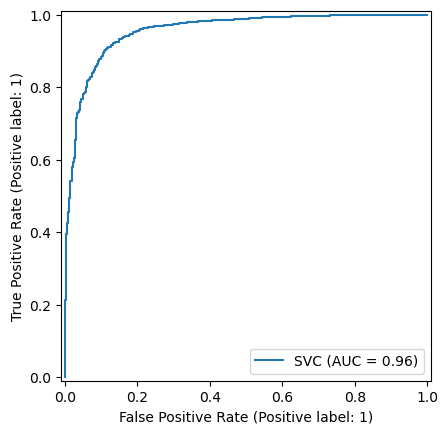

In [27]:
ROC_Curve=RocCurveDisplay.from_estimator(SVC_model,x_test,y_test)